In [166]:
import numpy as np
import pandas as pd
import copy
import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer
from collections import Counter

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
import PIL
from PIL import Image

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from evaluate import load

In [167]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [168]:
captions_path = "./train.csv"
images_path = "./train/"

In [169]:
df = pd.read_csv(captions_path)
print(len(df))
df.head()

74565


,img_name,img_path,mos,comments
0,41wy7upxzl,./train/41wy7upxzl.jpg,5.569231,"the pink and blue really compliment each other. like the dense color, blur."
1,ygujjq6xxt,./train/ygujjq6xxt.jpg,6.103175,love rhubarb! great colors!
2,wk321130q0,./train/wk321130q0.jpg,5.541985,i enjoy the textures and grungy feel to this. i also really like the deep rich red color.
3,w50dp2zjpg,./train/w50dp2zjpg.jpg,6.234848,"i like all the different colours in this pic, the brown, green, dark grey, light grey, cool image."
4,l7rqfxeuh0,./train/l7rqfxeuh0.jpg,5.190476,"i love these critters, just wish he was a little sharper, nice comp though."


## Data Preprocessing

In [170]:
stop_words = stopwords.words('english')
stop_words += ['would', 'youre', 'youve', 'youll', 'youd', 'shes', 'thatll', 'dont', 'shouldnt', 'shouldve', 'arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'wasnt', 'werent', 'wont', 'wouldnt']
stop_words += ['wow', 'woow', 'woowee', 'whoa', 'oh', 'ooh', 'woohoo', 'yes', 'ha', 'brr', 'duh', 'eww', 'hee', 'huh', 'hmm', 'hooray', 'jeez', 'omg', 'gosh', 'yay']

In [171]:
class my_dictionary(dict): 
    
    def __init__(self): 
        self = dict() 
          
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary() 

In [172]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    
    s = df.iloc[i, 3]
    s = re.sub('[^a-z]', ' ', s)
    sentence = ["<start>"] + word_tokenize(s) + ["<end>"]
    sentence = [word for word in sentence if len(word) > 1]
    sentence = [word for word in sentence if word not in stop_words]
    sentence = [word for word in sentence if 'haha' not in word]
    sentence = [word for word in sentence if 'hehe' not in word]
    sentence = [word for word in sentence if 'ah' not in word]
    
    descriptors.add(img_id, sentence)

In [173]:
print(descriptors['taibd7f1xk.jpg'])

[['<start>', 'one', 'pegged', 'blue', '<end>'], ['<start>', 'awesome', 'peaceful', 'almost', 'feel', 'myslef', 'love', 'colors', '<end>']]


In [174]:
token_counter = Counter()
class textVocab:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}
        self.stoi = {b:a for a, b in self.itos.items()}   
        self.min_freq = 2
        self.token_counter = Counter()

    def __len__(self):
        return len(self.itos)

    def numericalize(self, text):

        text = re.sub('[^a-z]', ' ', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if 'haha' not in word]
        tokens = [word for word in tokens if 'hehe' not in word]
        tokens = [word for word in tokens if 'ah' not in word]
        
        ans = []
        for token in tokens:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans

    def build_vocab(self, sentence_list):
        word_count = 4
        
        for sentence in sentence_list:
            
            sentence = re.sub('[^a-z]', ' ', sentence)
            tokens = word_tokenize(sentence)
            tokens = [word for word in tokens if len(word) > 1]
            tokens = [word for word in tokens if word not in stop_words]
            tokens = [word for word in tokens if 'haha' not in word]
            tokens = [word for word in tokens if 'hehe' not in word]
            tokens = [word for word in tokens if 'ah' not in word]
            
            token_counter.update(tokens)
            
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

In [175]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.img_ids = self.df["img_name"]
        self.sentences = self.df["comments"]
        self.vocab = textVocab()
        self.vocab.build_vocab(self.sentences.tolist())
        print(len(self.vocab))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        vec = []
        vec += [self.vocab.stoi["<start>"]]
        vec += self.vocab.numericalize(sentence)
        vec += [self.vocab.stoi["<end>"]]
        
        return img, torch.tensor(vec), img_id

In [176]:
weights = models.Inception_V3_Weights.DEFAULT
inception = models.inception_v3(weights=weights)
i = 0
for name, param in inception.named_parameters():  # named_parameters 가중치 뽑아주는 함수
    print(i,name)
    i+= 1
print(weights.transforms())

0 Conv2d_1a_3x3.conv.weight
1 Conv2d_1a_3x3.bn.weight
2 Conv2d_1a_3x3.bn.bias
3 Conv2d_2a_3x3.conv.weight
4 Conv2d_2a_3x3.bn.weight
5 Conv2d_2a_3x3.bn.bias
6 Conv2d_2b_3x3.conv.weight
7 Conv2d_2b_3x3.bn.weight
8 Conv2d_2b_3x3.bn.bias
9 Conv2d_3b_1x1.conv.weight
10 Conv2d_3b_1x1.bn.weight
11 Conv2d_3b_1x1.bn.bias
12 Conv2d_4a_3x3.conv.weight
13 Conv2d_4a_3x3.bn.weight
14 Conv2d_4a_3x3.bn.bias
15 Mixed_5b.branch1x1.conv.weight
16 Mixed_5b.branch1x1.bn.weight
17 Mixed_5b.branch1x1.bn.bias
18 Mixed_5b.branch5x5_1.conv.weight
19 Mixed_5b.branch5x5_1.bn.weight
20 Mixed_5b.branch5x5_1.bn.bias
21 Mixed_5b.branch5x5_2.conv.weight
22 Mixed_5b.branch5x5_2.bn.weight
23 Mixed_5b.branch5x5_2.bn.bias
24 Mixed_5b.branch3x3dbl_1.conv.weight
25 Mixed_5b.branch3x3dbl_1.bn.weight
26 Mixed_5b.branch3x3dbl_1.bn.bias
27 Mixed_5b.branch3x3dbl_2.conv.weight
28 Mixed_5b.branch3x3dbl_2.bn.weight
29 Mixed_5b.branch3x3dbl_2.bn.bias
30 Mixed_5b.branch3x3dbl_3.conv.weight
31 Mixed_5b.branch3x3dbl_3.bn.weight
32 Mixe

In [177]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3

        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2
        
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        
        self.AuxLogits = inception.AuxLogits
        
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

    def forward(self, x):

        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = self.maxpool1(x)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = self.maxpool2(x)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x = self.Mixed_7c(x)
        
        return x

In [178]:
inception_Transform = T.Compose([
    T.Resize(342),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [179]:
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = inception_Transform
)

9903


In [180]:
with open('vocab.pkl', 'wb') as file:
      
    pickle.dump(dataset.vocab, file)

In [181]:
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

03hgnq4mgk.jpg


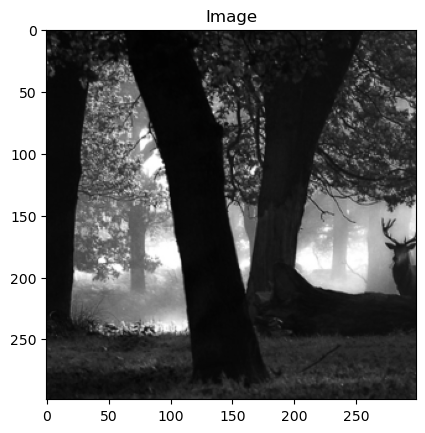

caption:  ['<start>', 'nice', 'capture', 'light', 'quality', 'nice', '<end>']


In [182]:
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

In [183]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value
        self.batch_first = batch_first
        
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        
        captions = [item[1] for item in batch]
        
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

In [184]:
batch_size = 10
pad_value = dataset.vocab.stoi["<PAD>"]

In [185]:
validation_split = .8
test_split = .9
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))

val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))
train_indices, val_indices, test_indices = indices[:val_split], indices[val_split:test_split], indices[test_split:]

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

In [186]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [187]:
train_loader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=batch_size, shuffle=False,
                                            collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                            sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=test_sampler)

little overdone contrast idea


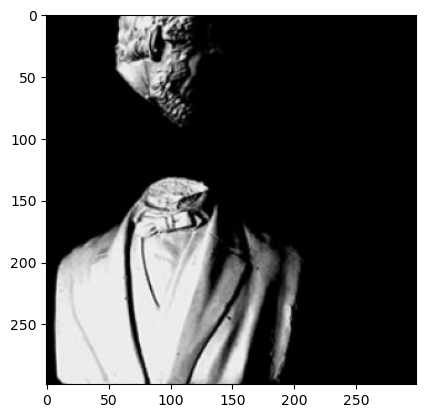

In [188]:
trainItr = iter(train_loader)
batch = next(trainItr)
imgs, captions, img_ids = batch

for i in range(batch_size):
    img, caption = imgs[i], captions[i]

    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]

    end_indx = sentence.index('<end>')

    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)

    print(sentence)
    show_image(img)
    plt.show()
    
    break

## Model

In [189]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.my_inception = MyInceptionFeatureExtractor(inception)
        
    def forward(self, images):
        # images.shape = [bs, 3, 299, 299]
        
        features = self.my_inception(images) 
        # features.shape = [bs, 2048, 8, 8]
        
        features = features.permute(0, 2, 3, 1)
        # features.shape = [bs, 8, 8, 2048]
        
        features = features.view(features.size(0), -1, features.size(-1))
        # features.shape = [bs, 64, 2048]
        
        return features

In [190]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
    
    def forward(self, features, hidden_states):
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))

        attention_scores = self.full_att(combined_states)
        attention_scores = attention_scores.squeeze(2)

        alpha = F.softmax(attention_scores, dim=1)

        weighted_encoding = features * alpha.unsqueeze(2)
        weighted_encoding = weighted_encoding.sum(dim=1)

        return alpha, weighted_encoding

In [191]:
import copy

class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        self.lstm_cell1 = nn.LSTMCell(dec_dim + embed_sz, dec_dim, bias=True)
        self.lstm_cell2 = nn.LSTMCell(enc_dim + dec_dim, dec_dim, bias = True)
        
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions, teacher):
        cap_len = len(captions[0]) - 1
        
        batch_sz = captions.size(0)
        num_features = features.size(1)
        embeds = self.embedding(captions)

        #h1, c1 = self.init_hidden_state(features)
        h1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        c1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        h2, c2 = h1.clone(), c1.clone()
        
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            # <start> or use teacher forcing according teacher * 100%
            if i == 0 or np.random.rand() < teacher:
                lstm_input1 = torch.cat((h2, embeds[:,i]), dim=1)
                #print(lstm_input.shape)
            else:
                # output 10,23756 -> argmax 10, 1 -> embed 10, 500
                output = [output[j, :].reshape(1, -1).argmax(dim=1).item() for j in range(batch_sz)]
                output = torch.tensor(np.array(output)).to(device)
                output = self.embedding(output)
                lstm_input1 = torch.cat((h2, output), dim=1)
            
            h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))
            alpha, att_weights = self.attention(features, h1)
            #print(att_weights.shape)
            lstm_input2 = torch.cat((att_weights, h1), dim=1)
            h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))

            output = self.fcn(self.drop(h2))
            #print(output.shape, h1.shape, c1.shape)

            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    def generate_caption(self, features, max_len=40, vocab=None, K=5):
        batch_sz = features.size(0)
        candidates = []
        final_candidates = []
        
        #h1, c1 = self.init_hidden_state(features)
        h1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        c1 = torch.zeros(batch_sz, self.dec_dim).to(device)
        h2, c2 = h1.clone(), c1.clone()
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # BeamSearch
        lstm_input1 = torch.cat((h2, embeds[:, 0]), dim=1)
        h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))    
        alpha, weighted_encoding = self.attention(features, h1)
        lstm_input2 = torch.cat((weighted_encoding, h1), dim=1)
        h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))
        output = self.fcn(self.drop(h2))
        output = output.view(batch_sz, -1)
        output = output.squeeze(dim=0)
        output = F.log_softmax(output, dim=0)
        for i in range(K):
            pred_word_idx = output.argmax(dim=0).item()
            candidates.append([output[pred_word_idx].item(), output[pred_word_idx].item(), (h1, c1, h2, c2), [pred_word_idx]])
            output[pred_word_idx] = -999999
        
        while len(final_candidates) < K:
            new_candidates = []
            for candidate in candidates:
                word = torch.tensor(candidate[3][-1]).view(1,-1).to(device)
                embeds = self.embedding(word)
                h1, c1, h2, c2 = candidate[2]
                lstm_input1 = torch.cat((h2, embeds[:, 0]), dim=1)
                h1, c1 = self.lstm_cell1(lstm_input1, (h1, c1))    
                alpha, weighted_encoding = self.attention(features, h1)
                lstm_input2 = torch.cat((weighted_encoding, h1), dim=1)
                h2, c2 = self.lstm_cell2(lstm_input2, (h2, c2))
                output = self.fcn(self.drop(h2))
                output = output.view(batch_sz, -1)
                output = output.squeeze(dim=0)
                output = F.log_softmax(output, dim=0)

                for j in range(K):
                    pred_word_idx = output.argmax(dim=0).item()
                    new_candidates.append(copy.deepcopy(candidate))
                    new_candidates[-1][1] += output[pred_word_idx].item()
                    new_candidates[-1][2] = (h1, c1, h2, c2)
                    new_candidates[-1][0] = new_candidates[-1][1] / (((5+len(new_candidates[-1][3])) / (5+1)) ** 1.2)
                    #new_candidates[-1][0] = new_candidates[-1][1] / len(new_candidates[-1][3])
                    new_candidates[-1][3] += [pred_word_idx]
                    output[pred_word_idx] = -99999

            new_candidates.sort(key=lambda x:x[0], reverse=True)
            candidates = new_candidates[:K]
            
            for candidate in candidates[::]:
                if vocab.itos[candidate[3][-1]] == '<end>' or len(candidate[3]) > 40:
                    final_candidates.append(candidate)
                    candidates.remove(candidate)
        
        final_candidates.sort(key=lambda x:x[0], reverse=True)
        captions += final_candidates[0][3]
                    
        return [vocab.itos[idx] for idx in captions], None
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        return h, c

In [192]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        
        # encoder freezing
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions, teacher):

        features = self.encoder(images)
        outputs = self.decoder(features, captions, teacher)

        return outputs

In [193]:
embed_sz = 100
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 0.00005

In [194]:
model = EncoderDecoder(
    embed_sz = 100,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [195]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])

#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=False)

## Train

In [196]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [79]:
print_each = 100
epochs = 20

<Figure size 640x480 with 0 Axes>

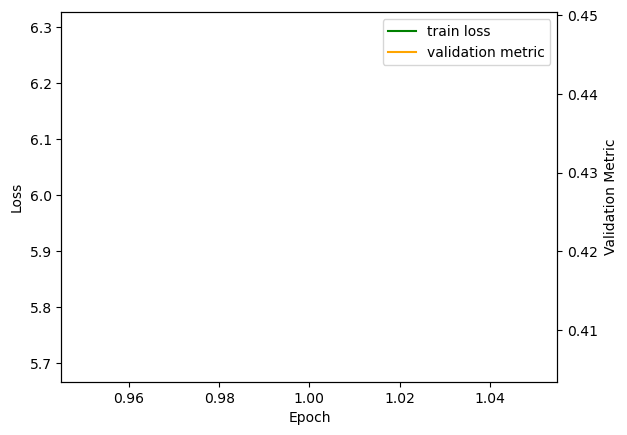

1 epochs : train_loss = 5.996426250392152, validation metric = 0.4269084181484673
BLEU: 0.298393
METEOR: 0.190797
BERT-Score: 0.879137
Rouge-L Score: 0.339307
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

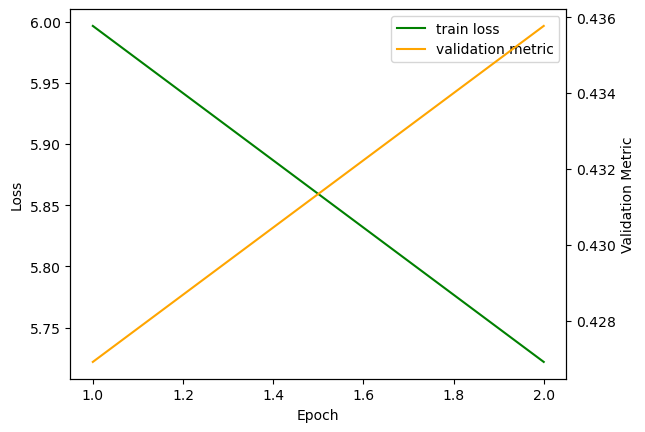

2 epochs : train_loss = 5.721981243964756, validation metric = 0.4357702006220597
BLEU: 0.318331
METEOR: 0.204569
BERT-Score: 0.880591
Rouge-L Score: 0.339590
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

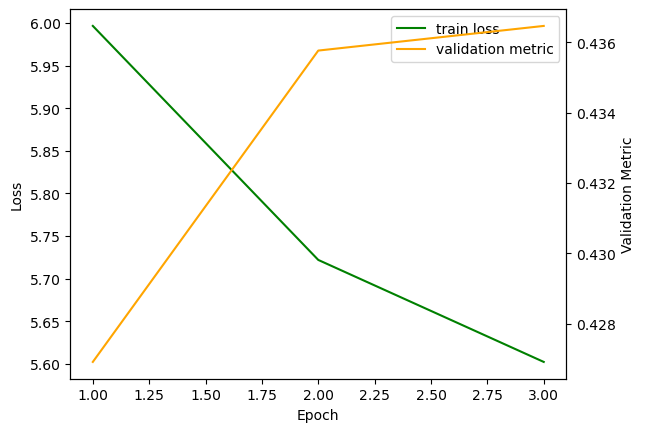

3 epochs : train_loss = 5.602363232938623, validation metric = 0.436471712200485
BLEU: 0.318373
METEOR: 0.204814
BERT-Score: 0.882794
Rouge-L Score: 0.339907
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

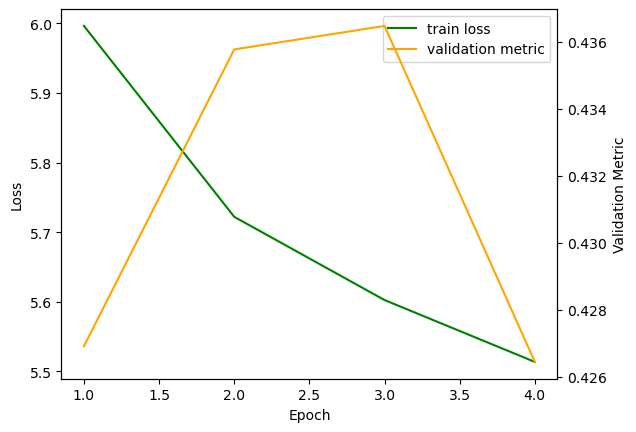

4 epochs : train_loss = 5.513440612047833, validation metric = 0.4264401866810539
BLEU: 0.303903
METEOR: 0.195865
BERT-Score: 0.879537
Rouge-L Score: 0.326455
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

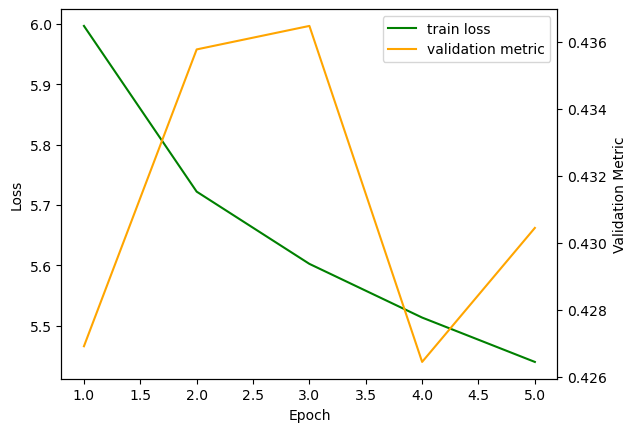

5 epochs : train_loss = 5.439993012545375, validation metric = 0.4304410068826713
BLEU: 0.313009
METEOR: 0.201823
BERT-Score: 0.880176
Rouge-L Score: 0.326756
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

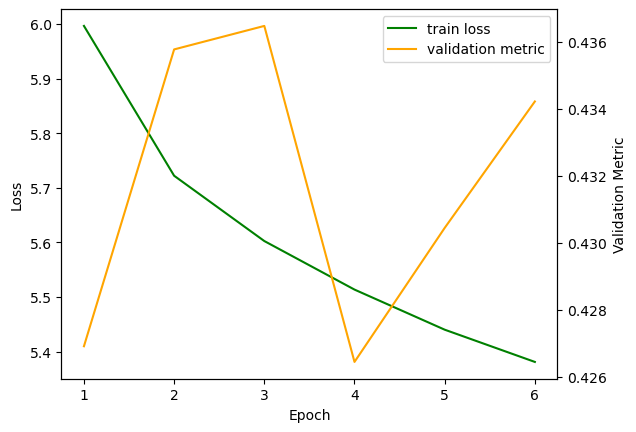

6 epochs : train_loss = 5.380924774281001, validation metric = 0.43421607451310695
BLEU: 0.324784
METEOR: 0.205433
BERT-Score: 0.881024
Rouge-L Score: 0.325622
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

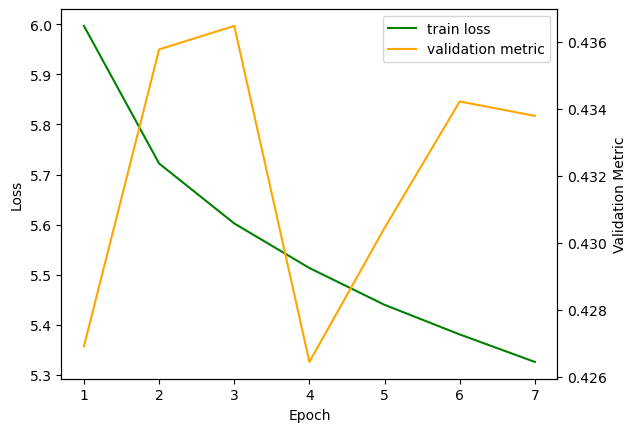

7 epochs : train_loss = 5.326079294522156, validation metric = 0.43378676721887516
BLEU: 0.324068
METEOR: 0.204818
BERT-Score: 0.880667
Rouge-L Score: 0.325595
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

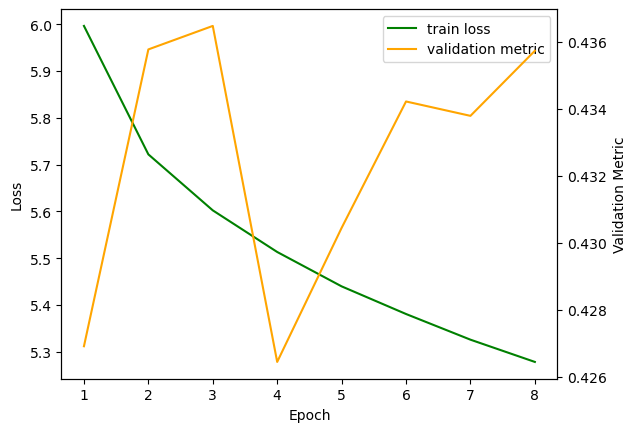

8 epochs : train_loss = 5.278539060227374, validation metric = 0.43572926925529876
BLEU: 0.324039
METEOR: 0.208068
BERT-Score: 0.880312
Rouge-L Score: 0.330498
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

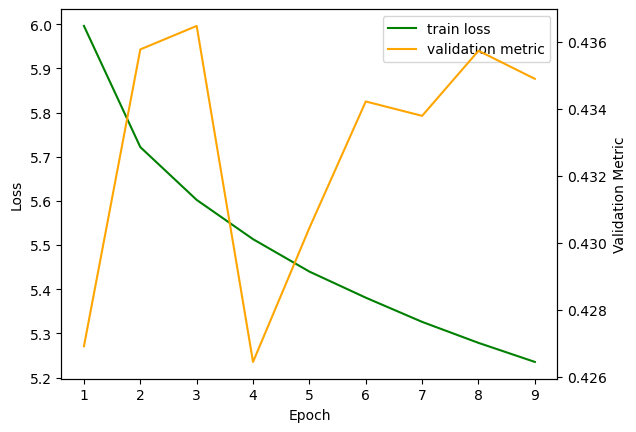

9 epochs : train_loss = 5.235408386386057, validation metric = 0.4348924906567259
BLEU: 0.327103
METEOR: 0.206555
BERT-Score: 0.879632
Rouge-L Score: 0.326280
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

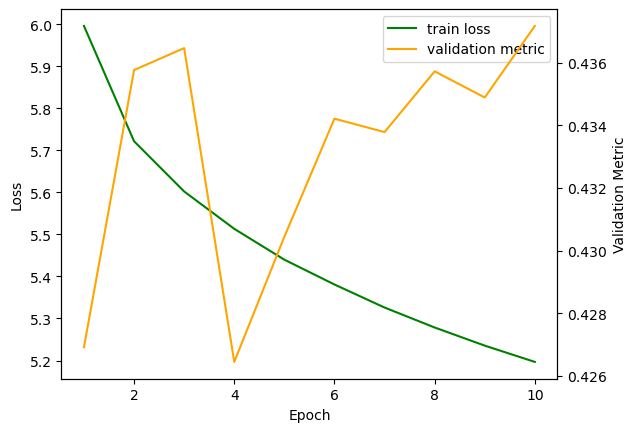

10 epochs : train_loss = 5.19661745718609, validation metric = 0.43718089854592745
BLEU: 0.331900
METEOR: 0.211771
BERT-Score: 0.879739
Rouge-L Score: 0.325315
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

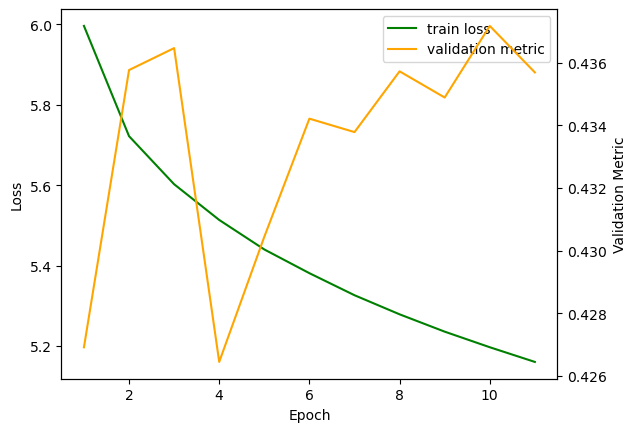

11 epochs : train_loss = 5.160060383652742, validation metric = 0.43569519047023936
BLEU: 0.325021
METEOR: 0.209134
BERT-Score: 0.879572
Rouge-L Score: 0.329054
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

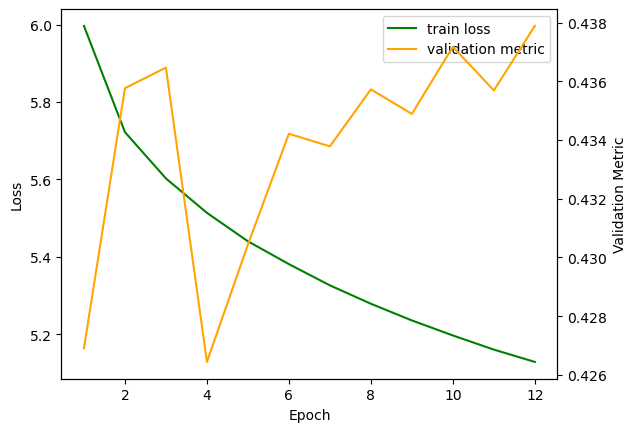

12 epochs : train_loss = 5.1282623196594646, validation metric = 0.43789216554533095
BLEU: 0.328375
METEOR: 0.211650
BERT-Score: 0.881657
Rouge-L Score: 0.329886
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

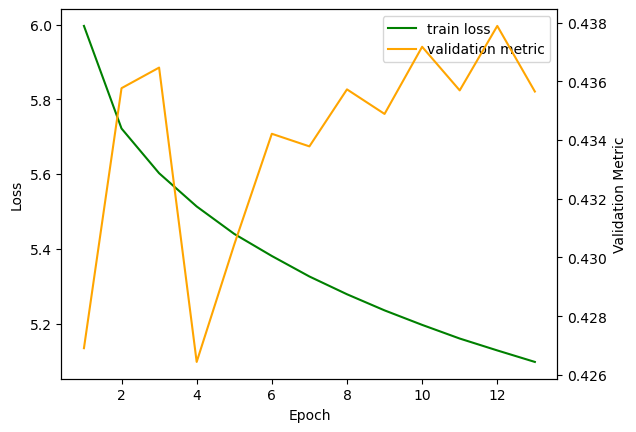

13 epochs : train_loss = 5.097510544561343, validation metric = 0.43565634435521705
BLEU: 0.326401
METEOR: 0.210613
BERT-Score: 0.879593
Rouge-L Score: 0.326019
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

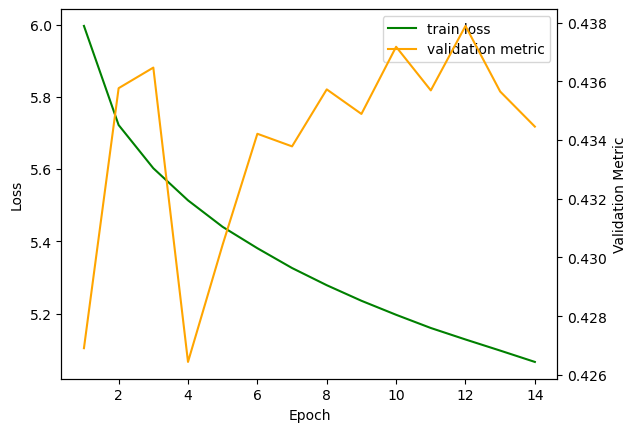

14 epochs : train_loss = 5.066118501429026, validation metric = 0.43446054175657517
BLEU: 0.325508
METEOR: 0.210000
BERT-Score: 0.878483
Rouge-L Score: 0.323851
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

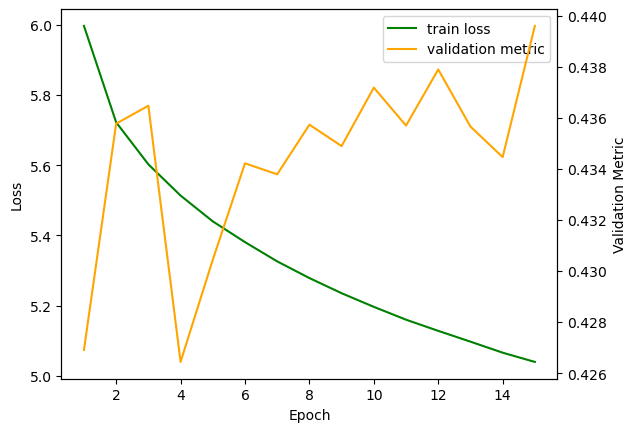

15 epochs : train_loss = 5.0398124544095975, validation metric = 0.4395968833938524
BLEU: 0.332606
METEOR: 0.215830
BERT-Score: 0.880489
Rouge-L Score: 0.329462
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

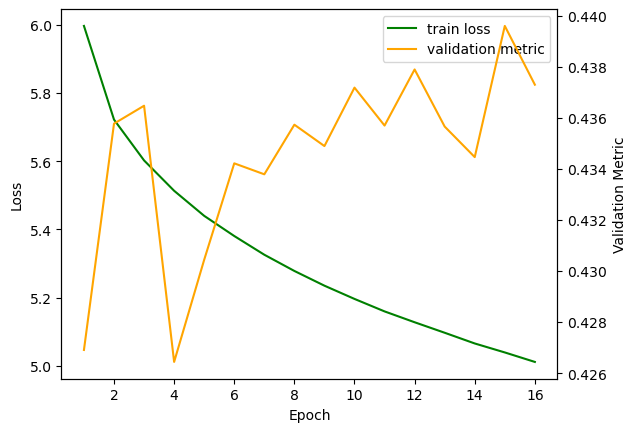

16 epochs : train_loss = 5.012039256185415, validation metric = 0.43729570001263024
BLEU: 0.328659
METEOR: 0.212089
BERT-Score: 0.879286
Rouge-L Score: 0.329148
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

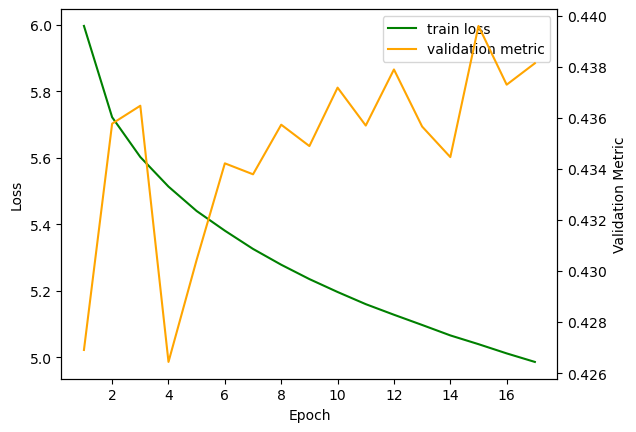

17 epochs : train_loss = 4.986421393731034, validation metric = 0.4381343467895291
BLEU: 0.327366
METEOR: 0.212137
BERT-Score: 0.881230
Rouge-L Score: 0.331803
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

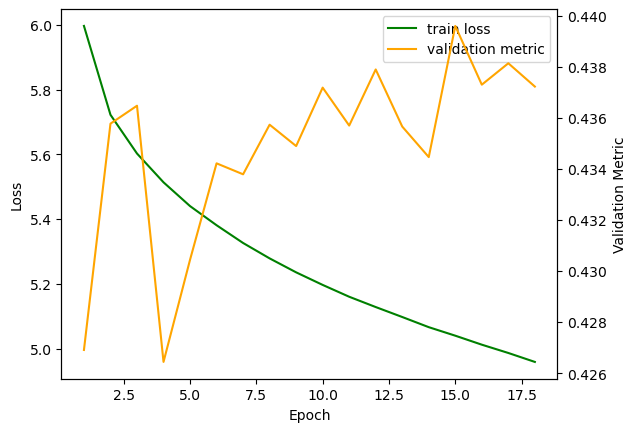

18 epochs : train_loss = 4.958798302248723, validation metric = 0.4372223117825339
BLEU: 0.330065
METEOR: 0.211236
BERT-Score: 0.879858
Rouge-L Score: 0.327730
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

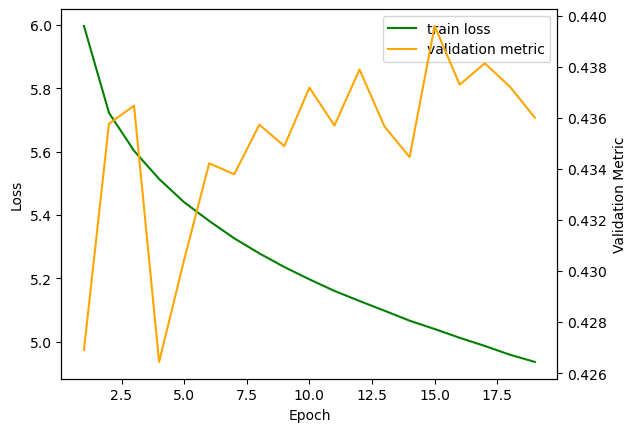

19 epochs : train_loss = 4.935957302567881, validation metric = 0.43600149707796704
BLEU: 0.326757
METEOR: 0.211479
BERT-Score: 0.878856
Rouge-L Score: 0.326913
current learning rate : 5e-05


<Figure size 640x480 with 0 Axes>

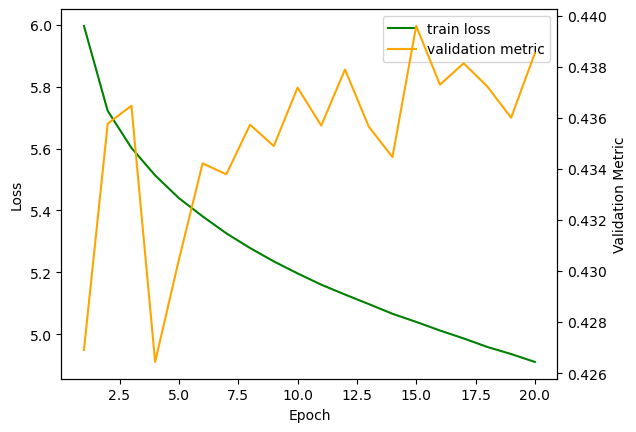

20 epochs : train_loss = 4.910502958080302, validation metric = 0.4385312752601484
BLEU: 0.329366
METEOR: 0.213335
BERT-Score: 0.881989
Rouge-L Score: 0.329436
current learning rate : 5e-05


In [80]:
train_loss = []
val_metric = []
highest_val = 0
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for epoch in range(1, epochs+1):
    model.train()
    train_loss.append(0)
    val_metric.append(0)
    for idx, (img, captions, img_ids) in enumerate(iter(train_loader)):

        img, captions = img.to(device), captions.to(device)
        targets = captions[:, 1:]
        
        optimizer.zero_grad()
        
        pred_caps, attentions = model(img, captions, teacher=max(0, 1 - 0.005 * epoch))
        
        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
        train_loss[-1] += loss.item() * train_loader.batch_size
        
        loss.backward()
        optimizer.step()
    
    # Validaion calculate
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0

    for idxx, (img, captions, img_ids) in enumerate(iter(val_loader)):
        with torch.no_grad():
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                
                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    bleu = bleu / len(val_sampler)
    meteor = meteor / len(val_sampler)
    bert_score = bert_score / len(val_sampler)
    rougescore = rougescore / len(val_sampler)
    
    train_loss[-1] = train_loss[-1] / len(train_sampler)
    val_metric[-1] = bleu/4 + meteor/4 + bert_score/4 + rougescore/4
    #scheduler.step(val_metric[-1])
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    line1 = ax1.plot(list(range(1, epoch+1)), train_loss, color = 'green', label='train loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Metric')
    line2 = ax2.plot(list(range(1, epoch+1)), val_metric, color = 'orange', label='validation metric')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    plt.show()
    print(str(epoch) + " epochs : train_loss = " + str(train_loss[-1]) + ", validation metric = " + str(val_metric[-1]))
    print('BLEU: %f' % bleu)
    print('METEOR: %f' % (meteor))
    print('BERT-Score: %f' % (bert_score))
    print('Rouge-L Score: %f' % (rougescore))
    print("current learning rate : " + str(optimizer.param_groups[0]['lr']))
    
    # save latest model
    #if highest_val < val_metric[-1]:
    PATH = './weights/IQA_no11_' + str(epoch) + 'epochs.pt'
    torch.save(model.state_dict(), PATH)
    #highest_val = val_metric[-1]

In [ ]:
# PATH = './weights/IQA_no3_11epochs.pt'
# torch.save(model.state_dict(), PATH)

## Test

In [197]:
PATH = './weights/IQA_no11_15epochs.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Original: <start> noise awful please quickly run <UNK> noise reduction algorithm flat uninteresting appreciate <end>
Predicted: <start> nice use light shadow <end>


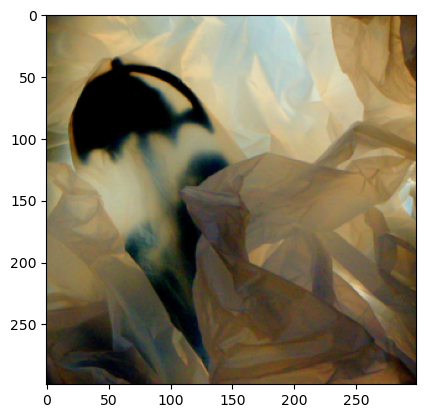

In [201]:
model.eval()
with torch.no_grad():
    itr = iter(val_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0]
    print("Original:", ' '.join(s))
    
    features = model.encoder(img[0:1].to(device))

    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [199]:
bertscorer = load("bertscore")
rougescorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluateModel(model, dls):
    model.eval()
    bleu, meteor, bert_score, rougescore = 0, 0, 0, 0
    
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            for i in range(batch_size):
                if len(captions[i:i+1]) == 0:
                    break
                    
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                bleu += sentence_bleu(descriptors[img_ids[i]], pred_caps, weights=(1.0, 0, 0, 0))
                meteor += meteor_score(descriptors[img_ids[i]], pred_caps)
                bert_score_tmp, rougescore_tmp = 0, 0
                for j in range(len(descriptors[img_ids[i]])):
                    bert_score_tmp += bertscorer.compute(predictions=[' '.join(pred_caps)], references=[' '.join(descriptors[img_ids[i]][j])], model_type="distilbert-base-uncased")['f1'][0]
                    rougescore_tmp += rougescorer.score(' '.join(pred_caps), ' '.join(descriptors[img_ids[i]][j]))['rougeL'].fmeasure
                bert_score += bert_score_tmp / len(descriptors[img_ids[i]])
                rougescore += rougescore_tmp / len(descriptors[img_ids[i]])
    
    print('BLEU: %f' % (bleu / len(val_sampler)))
    print('METEOR: %f' % (meteor / len(test_sampler)))
    print('BERT-Score: %f' % (bert_score / len(test_sampler)))
    print('Rouge-L Score: %f' % (rougescore / len(test_sampler)))

In [200]:
evaluateModel(model, test_loader)

0


C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\skghg\anaconda3\envs\daycon\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
